In [ ]:
# Import libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.model_selection import cross_val_score


from nltk.stem import SnowballStemmer

# To balace the data set
from imblearn.over_sampling import SMOTE

from wordcloud import WordCloud
import pickle



In [2]:
df = pd.read_csv("E:\documents\commited projects\Machine Learning\Sms-Spam-Detection\spam.csv", encoding='latin1')

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\JASIM\AppData\Local\Temp\ipykernel_2412\2097171646.py:1: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv("E:\documents\commited projects\Machine Learning\Sms-Spam-Detection\spam.csv", encoding='latin1')


In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## Data Cleaning

In [5]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [6]:
# I'm gonna remove 3 coluumns which is almost null and not import at all

df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [7]:
# renaming the columns 

df.rename(columns = {'v1': 'target',
                    'v2': 'message'}, inplace=True)

In [8]:
df.isnull().sum()

target     0
message    0
dtype: int64

In [9]:
# Checking for duplicates values
df.duplicated().sum()

403

In [10]:
# Removing ducplicates
df = df.drop_duplicates(keep='first')

# EDA

In [11]:
df['target'].value_counts()

target
ham     4516
spam     653
Name: count, dtype: int64

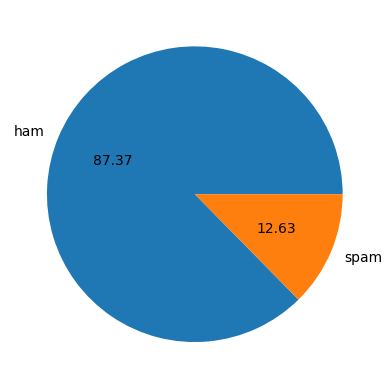

In [12]:
# The classification of ham and spam sms
plt.pie(df['target'].value_counts(), labels = ['ham', 'spam'],autopct= '%0.2f')
plt.show()

In [13]:
# The number of caracter in each message
df['number_of_caracters'] = df['message'].apply(len)

In [14]:
# The number of words in each message
import nltk
df['number_of_words'] = df['message'].map(lambda x: len(nltk.word_tokenize(x)))

# Same for sentence
df['number_of_sentences'] = df['message'].map(lambda x: len(nltk.sent_tokenize(x)))
df['number_of_wordsIn_sentence'] = df['number_of_words'] / df['number_of_sentences']

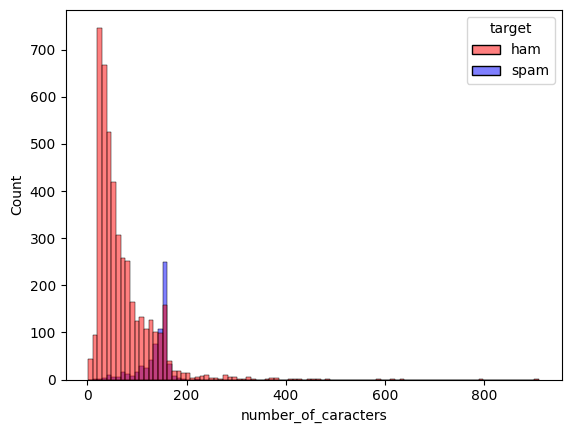

In [15]:
# The distribution of spam and ham caracters wise
sns.histplot(data=df, x='number_of_caracters', hue='target', palette={'spam': 'blue', 'ham': 'red'})
plt.show()

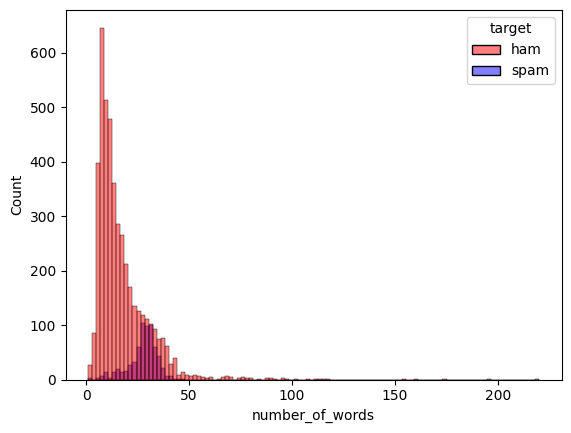

In [16]:
# The distribution of spam and ham words wise
sns.histplot(data=df, x='number_of_words', hue='target', palette={'spam': 'blue', 'ham': 'red'})
plt.show()

<Axes: xlabel='number_of_sentences', ylabel='count'>

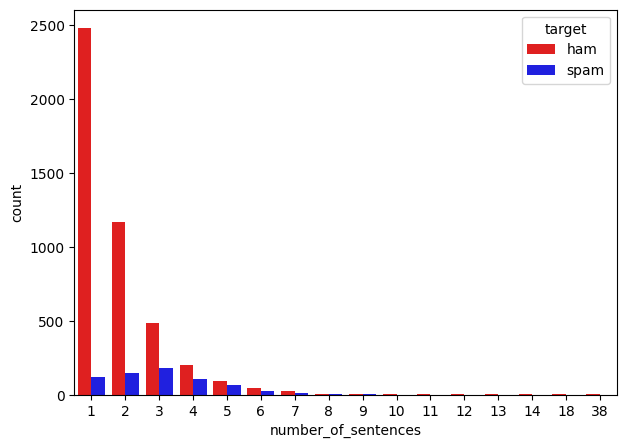

In [17]:
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='number_of_sentences', hue='target', palette={'spam': 'blue', 'ham': 'red'})

In [18]:
# Transform the target to the binary
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])

<Axes: >

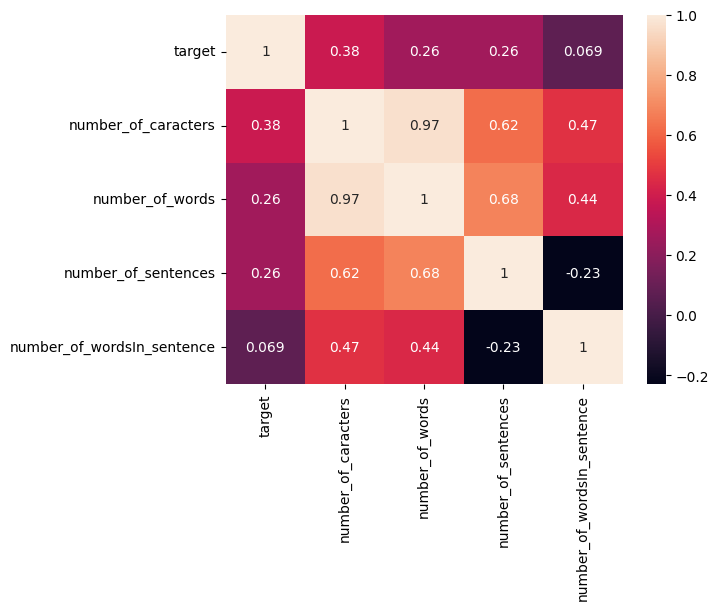

In [19]:
sns.heatmap(df.drop(columns = 'message').corr(), annot=True)

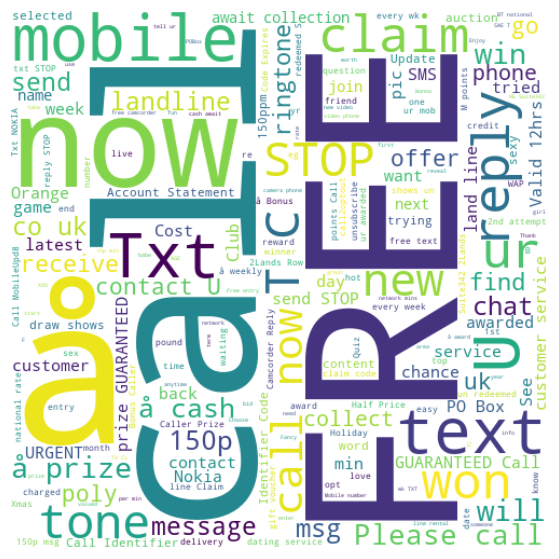

In [20]:
wcloud = WordCloud(width=500, height=500, background_color='white')

text1 = df[df['target'] == 1]['message'].str.cat(sep="")
text1cloud = wcloud.generate(text1)

# Displaying the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(text1cloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()

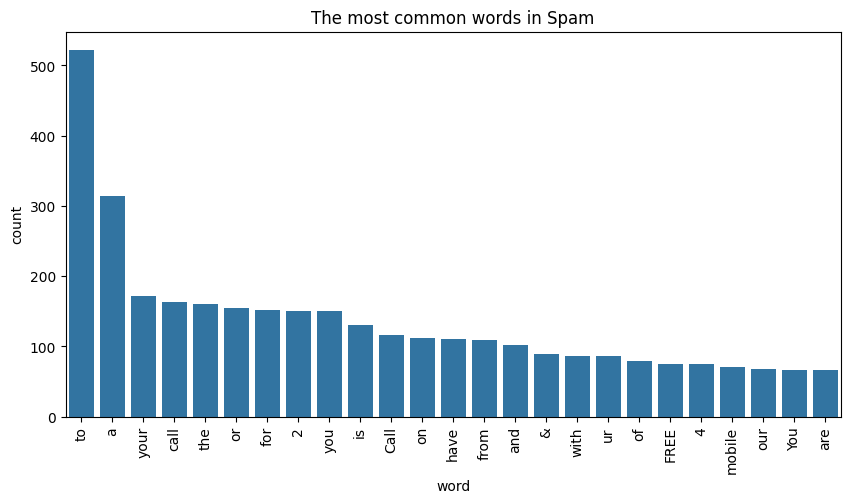

In [21]:
from collections import Counter

listof1 = df[df['target'] == 1]['message'].tolist()
wordcount1 = []
for row in listof1:
    for word in row.split():
        wordcount1.append(word)

wordcount1df = pd.DataFrame(Counter(wordcount1).most_common(25), columns=['word', 'count'])

plt.figure(figsize = (10, 5))
sns.barplot(x ='word', y='count', data =wordcount1df)
plt.title("The most common words in Spam")
plt.xticks(rotation='vertical')
plt.show()

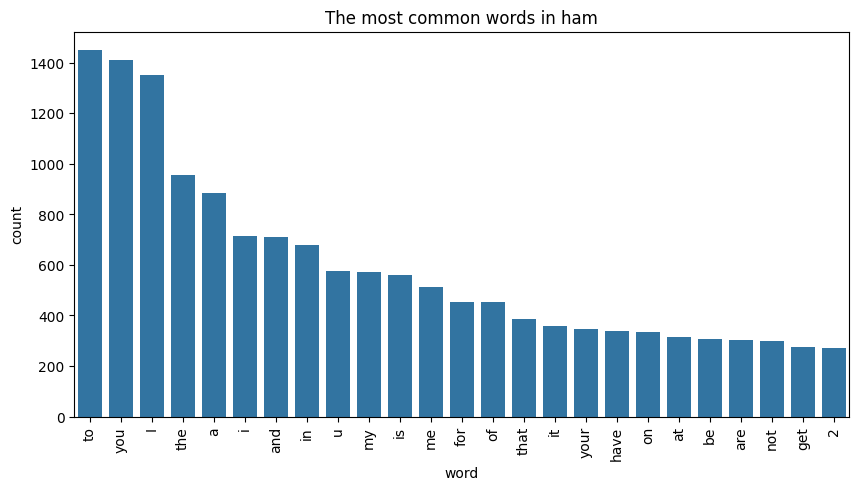

In [22]:
from collections import Counter
listof0 = df[df['target'] == 0]['message'].tolist()
wordcount0 = []
for row in listof0:
    for word in row.split():
        wordcount0.append(word)

wordcount0df = pd.DataFrame(Counter(wordcount0).most_common(25), columns=['word', 'count'])

plt.figure(figsize = (10, 5))
sns.barplot(x ='word', y='count', data =wordcount0df)
plt.title("The most common words in ham")
plt.xticks(rotation='vertical')
plt.show()

   # Preprocesses the given text: 
    - Converts to lowercase
    - Tokenizes into words
    - Remove single character 
    - Removes stopwords
    - Applies stemming

In [320]:
# Processing the given text
def text_processing(data):
    stop_words = stopwords.words('english')
    stemmer = SnowballStemmer('english') #PorterStemmer('english')
    
    # Change everything to lowercase
    data = data.lower()

    # tokenzer breaking down text into smaller, manageable pieces.
    wordtokenize = nltk.word_tokenize(data)


    # this part will remove punctuation from the data
    filter_tokenzie = []
    for word in wordtokenize:
        if word.isalnum(): # ignore punctuation and ignore token if it's single character
            filter_tokenzie.append(word)
    
    # removing stop words from the data
    sw_filter = []
    for word in filter_tokenzie:
        if word not in stop_words:
            sw_filter.append(word)

    #
    # stemming the words
    stem_word = []
    for word in sw_filter:
        stem_word.append(stemmer.stem(word))
        
    # joining the stemmed words back to form a sentence
    return " ".join(stem_word)

In [321]:
text_processing("FreeMsg Hey there loved darling it's 666 h k been 3 week's %$# now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv")

'freemsg hey love darl 666 h k 3 week word back like fun still tb ok xxx std chgs send rcv'

In [322]:
text_processing('I Loved the YT lectures on Machine learning. how about you?')

'love yt lectur machin learn'

In [324]:
# applying the cleaning function on message
df['modify_message'] = df['message'].apply(text_processing)

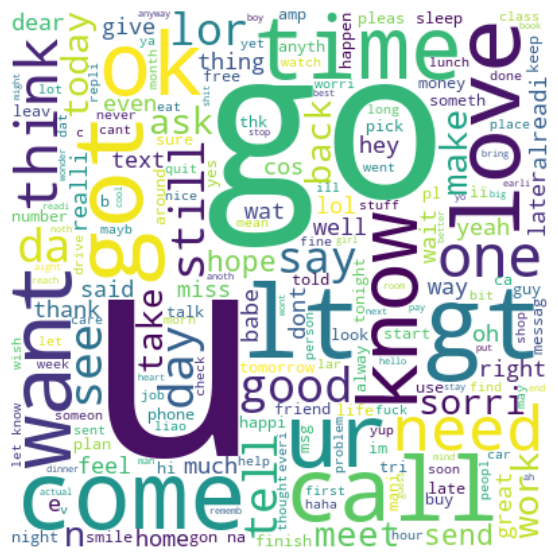

In [325]:
from wordcloud import WordCloud

# Generating the word cloud
wcloud = WordCloud(width=400, height=400, background_color='white')
text0 = df[df['target'] == 0]['modify_message'].str.cat(sep=" ")
wcloud.generate(text0)

# Displaying the word cloud
plt.figure(figsize=(7, 7))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()

# Model building

In [326]:
# Transforms text data into numerical representations: 
# CountVectorizer creates a bag-of-words model, and TfidfVectorizer creates a TF-IDF representation, both limited to the top 3000 features.

count_vec = CountVectorizer(max_features = 3000)#
tfidf_vec = TfidfVectorizer(max_features = 3000)

In [338]:
# Transforms the 'modify_message' column in the DataFrame into a numerical feature matrix using TF-IDF, 
# and stores it as a NumPy array in 'x'. The target labels are stored in 'y'.

x = tfidf_vec.fit_transform(df['modify_message']).toarray()
y = df['target']

In [328]:
x.shape

(5169, 3000)

## Balancing The Data

In [329]:
# Apply SMOTE after transforming text
smote = SMOTE()
x,y=smote.fit_resample(x, y)

In [330]:
y.value_counts()

target
0    4516
1    4516
Name: count, dtype: int64

In [331]:
# split testing data and training data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=41)

# Each Model Scores

- Calculate accuracy using accuracy_score.
- Generate a classification report to analyze precision, recall, and F1-score.
- Perform 5-fold cross-validation to get the average accuracy across different splits.
- Print the accuracy, cross-validation score, and classification report for each model.

In [332]:
# Models 
Models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "MultinomialNB": MultinomialNB(),
    "GaussianNB": GaussianNB(),
    "BernoulliNB": BernoulliNB(),
    "Linear SVM": LinearSVC(),
}

# Train, Predict, and Evaluate
for i, model in Models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cv_scores = cross_val_score(model,x, y, scoring='accuracy', cv= 5)
    
    
    # print accuracy and cross_val_score for each model
    print(f"{i} Accuracy Score: {accuracy}")
    print(f"Cross val Score: {np.mean(cv_scores)}")
    print(f"Classification Report: \n{report}")
    print("="*60)

Logistic Regression Accuracy Score: 0.9562811289429994
Cross val Score: 0.9496233118284314
Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       917
           1       0.98      0.93      0.95       890

    accuracy                           0.96      1807
   macro avg       0.96      0.96      0.96      1807
weighted avg       0.96      0.96      0.96      1807

Random Forest Accuracy Score: 0.993912562257886
Cross val Score: 0.990811296784193
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       917
           1       1.00      0.99      0.99       890

    accuracy                           0.99      1807
   macro avg       0.99      0.99      0.99      1807
weighted avg       0.99      0.99      0.99      1807

MultinomialNB Accuracy Score: 0.9728832318760376
Cross val Score: 0.9725427937741807
Classification Report: 
              p

# Best Model Tunining And Testing

### BNB Perameter Tuning

In [333]:
bnb = BernoulliNB()

bnb.fit(x_train, y_train)
bnb_pred = bnb.predict(x_test)

print("Accuracy Score:", accuracy_score(y_test, bnb_pred))
print("Precision  Score:", precision_score(y_test, bnb_pred))
print()
print("Confusion Matrix:\n", confusion_matrix(y_test, bnb_pred))

Accuracy Score: 0.9811842833425567
Precision  Score: 1.0

Confusion Matrix:
 [[917   0]
 [ 34 856]]


### BNB After threshold adjustments

In [334]:
# Predict probabilities for the positive class (class 1) using the Bernoulli Naive Bayes (bnb) model.
# Convert probabilities to binary predictions using a custom threshold of 0.25.
# If the predicted probability is >= 0.25, classify it as 1; otherwise, classify it as 0.

y_proba_bnb = bnb.predict_proba(x_test)[:, 1]
bnb_thresholds = (y_proba_bnb >= 0.25).astype(int)

print("Accuracy Score:", accuracy_score(y_test, bnb_thresholds))
print("Precision Score:", precision_score(y_test, bnb_thresholds))
print()
print("Confusion Matrix:\n", confusion_matrix(y_test, bnb_thresholds))

Accuracy Score: 0.9833978970669618
Precision Score: 0.9988399071925754

Confusion Matrix:
 [[916   1]
 [ 29 861]]


### Perameter Tuning Randomforest

In [335]:
RFC_Model = RandomForestClassifier(random_state=2, n_estimators=300, criterion='log_loss')#

RFC_Model.fit(x_train, y_train)

y_pred_rfr = RFC_Model.predict(x_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred_rfr))
print("Precision  Score:", precision_score(y_test, y_pred_rfr))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rfr))

Accuracy Score: 0.9900387382401771
Precision  Score: 0.9898876404494382
Confusion Matrix:
 [[908   9]
 [  9 881]]


#### RFR After threshold adjustments

In [336]:
rfr_threshold = 0.60

y_proba_rfr = RFC_Model.predict_proba(x_test)[:, 1]
rfr_thresholds = (y_proba_rfr >= rfr_threshold).astype(int)

print("Accuracy Score:", accuracy_score(y_test, rfr_thresholds))
print("Precision  Score:", precision_score(y_test, rfr_thresholds))
print()
print("Confusion Matrix:\n", confusion_matrix(y_test, rfr_thresholds))

Accuracy Score: 0.9922523519645822
Precision  Score: 0.9988610478359908

Confusion Matrix:
 [[916   1]
 [ 13 877]]


In [337]:
# Recall
recall_rfr = 870/(870+29)

# Precision
precision_rfr = 870/(870+1)

print(f'Randomforest Recall: {recall_rfr}')
print(f'Randomforest Precision: {precision_rfr}')

Randomforest Recall: 0.967741935483871
Randomforest Precision: 0.9988518943742825


# Saving the model

In [319]:
# Save the model data to a dictionary with threshold for easy loading
model_data = {
    "model": RFC_Model,
    "threshold": rfr_threshold
}

# Save the model as pickle
with open("Model.pkl", "wb") as model:
    pickle.dump(model_data, model)

# Save the Victorizerr as pickle
with open("Tfidf.pkl", "wb") as v:
    pickle.dump(tfidf_vec, v)